# **Análisis Zonas Ciudad de México**

**Objetivo de Negocio**: Identificar la mejor zona para invertir en la CDMX asegurando una alta ocupación y satisfacción de los huéspedes.

**Objetivo analítico** : Identificar patrones y tendencias para la toma de decisiones de inversión a través de datos históricos de Airbnb

**Caso de estudio**: El Sr. Martínez desea invertir en una propiedad en la CDMX la cuál tiene interés de invertir en un airbnb considerando que en un futuro se posicione como uno de los favoritos por los huéspedes, para esto desea conocer cuáles es la zonas en la cuál su inversión sea la mejor así como las características adicionales requeridas para su inversión

**Metas específicas**:

* Determinar qué zonas tienen la mayor tasa de ocupación.

* Identificar los ingresos promedio por zona.

* Evaluar la relación entre ingresos y ocupación para recomendar la zona más rentable

El siguiente notebook contiene el análisis de los datos compartido en la página [InsideAirbnb](https://insideairbnb.com/get-the-data/) de la Ciudad de México, los cuáles se encuentran actualizados históricamente hasta el mes de Junio de 2024 y no contiene información que comprometa la confidencialidad de los residente y/o anfitriones.

El contenido del notebook integra lo siguiente:


*   Carga de datos,contenido y limpieza de datos
*   Análisis de tipos de propiedades
*   Zonas con visitantes
*   Precios
*   Demanda, popularidad y disponibilidad
*   Reviews y satisfacción




# Extracción de Información

In [2]:
## Importación de librerías requeridas
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import IPython

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Carga de bases de datos
path_listings = "/content/drive/MyDrive/listings_detailed.csv"
listings = pd.read_csv(path_listings)

path_reviews = "/content/drive/MyDrive/reviews.csv"
reviews = pd.read_csv(path_reviews)

path_neighbourhoods = "/content/drive/MyDrive/neighbourhoods.csv"
neighbourhoods = pd.read_csv(path_neighbourhoods)

path_calendar = "/content/drive/MyDrive/calendar.csv"
calendar = pd.read_csv(path_calendar)

Las bases de datos a utilizar contienen información sobre los airbnb de la CDMX:
- Listings: Nombre del apartamento, nombre host, localidad, ubicación, tipo apartamento, precio, número de reviews
- calendar: Disponibilidad, fechas, precio, minimo de noches y maximo de noches del airbnb
- Reviews: Contiene id como identificador y fecha de reviews
- Neighbourhoods: Información de las localidades

**Disclaimer**:

Inside Airbnb obtiene datos de alquileres a corto plazo a través de la recopilación de información pública en el sitio web de Airbnb, incluyendo listados, precios y calificaciones. Nuestra organización utilizará estos datos para analizar el mercado de alquileres en varias ciudades, identificando tendencias y evaluando la competitividad de precios. Es importante mencionar que estos datos son proporcionados con fines educativos y de investigación, y pueden no representar la totalidad del mercado, por lo que su uso debe ser considerado con precaución.

## Análisis Zonas

## Calendario

El tabla de calendario registra el precio, la disponibilidad y otros detalles del calendario del listado para cada día de los próximos 365 días

In [5]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,44616,2024-06-28,f,"$18,000.00",NaN,1.0,365.0
1,898633,2024-06-28,f,$93.00,NaN,3.0,48.0
2,898633,2024-06-29,f,$93.00,NaN,3.0,48.0
3,898633,2024-06-30,f,$93.00,NaN,3.0,48.0
4,898633,2024-07-01,f,$93.00,NaN,3.0,48.0


In [8]:
calendar.shape

(9685643, 7)

In [20]:
listings.shape

(26536, 75)

In [9]:
calendar.dtypes

,0
listing_id,int64
date,object
available,object
price,object
adjusted_price,float64
minimum_nights,float64
maximum_nights,float64


Al realizar una inspección, se ha observado que las variables de precio y disponibilidad están almacenadas en un formato no numérico. Por lo tanto, es necesario transformar estas variables en un tipo de dato numérico para facilitar el análisis.



Primeramente, es necesario cambiar el tipo de valor de texto a númerico de la columna Price

In [22]:
# Eliminar símbolos de dólar y comas, y luego convertir a número
calendar['price_numeric'] = calendar['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

Se busca analizar la ocupación y el precio promedio por zona para estimar los ingresos potenciales, considerando el nivel de disponibilidad actual.

In [11]:
df_alcaldia = listings[['id','neighbourhood_cleansed','price_numeric']]

df_calendar_alcaldia = pd.merge(df_alcaldia, calendar, how='inner', left_on='id', right_on='listing_id')

In [13]:
df_calendar_alcaldia.head()

,id,neighbourhood_cleansed,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,price_numeric
0,898633,Cuauhtémoc,898633,2024-06-28,f,$93.00,NaN,3.0,48.0,93.0
1,898633,Cuauhtémoc,898633,2024-06-29,f,$93.00,NaN,3.0,48.0,93.0
2,898633,Cuauhtémoc,898633,2024-06-30,f,$93.00,NaN,3.0,48.0,93.0
3,898633,Cuauhtémoc,898633,2024-07-01,f,$93.00,NaN,3.0,48.0,93.0
4,898633,Cuauhtémoc,898633,2024-07-02,f,$93.00,NaN,3.0,48.0,93.0


In [14]:
print(f"El rango de fechas es de: {df_calendar_alcaldia.date.min()}, hasta {df_calendar_alcaldia.date.max()}")

El rango de fechas es de: 2024-06-27, hasta 2025-06-27


In [15]:
# Convertir la columna 'available' a 1 para 't' y 0 para 'f'
df_calendar_alcaldia['available_binary'] = df_calendar_alcaldia['available'].apply(lambda x: 1 if x == 't' else 0)


In [16]:

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Agrupar por 'neighbourhood_cleansed' y calcular el porcentaje de ocupación promedio y el precio mediana
df_resumen_ocupacion_precio = df_calendar_alcaldia.groupby('neighbourhood_cleansed').agg(
    porcentaje_disponibilidad=('available_binary', 'mean'),  # Promedio de disponibilidad
    precio_mediana=('price_numeric', 'median')                # Precio Mediana
)

# Agrupar por 'neighbourhood_cleansed' y calcular el porcentaje de ocupación promedio y el precio promedio
df_resumen_ocupacion_precio2 = df_calendar_alcaldia.groupby('neighbourhood_cleansed').agg(
    porcentaje_disponibilidad=('available_binary', 'mean'),  # Promedio de disponibilidad
    precio_promedio=('price_numeric', 'mean')                # Precio Media
)

# Le sacamos el complemento a la disponibilidad, que es la ocupación
df_resumen_ocupacion_precio['porcentaje_ocupacion'] = 1 - df_resumen_ocupacion_precio['porcentaje_disponibilidad']
df_resumen_ocupacion_precio2['porcentaje_ocupacion'] = 1 - df_resumen_ocupacion_precio2['porcentaje_disponibilidad']


# Calcular el Ingreso Anual estimado
df_resumen_ocupacion_precio['Ingreso_Anual'] = df_resumen_ocupacion_precio['precio_mediana'] * 365 * (df_resumen_ocupacion_precio['porcentaje_ocupacion'])
df_resumen_ocupacion_precio2['Ingreso_Anual'] = df_resumen_ocupacion_precio2['precio_promedio'] * 365 * (df_resumen_ocupacion_precio2['porcentaje_ocupacion'])

# Ordenar por 'Ingreso_Anual' en orden descendente
df_resumen_ocupacion_precio = df_resumen_ocupacion_precio.sort_values(by='Ingreso_Anual', ascending=False)
df_resumen_ocupacion_precio2 = df_resumen_ocupacion_precio2.sort_values(by='Ingreso_Anual', ascending=False)




In [17]:
# Mostrar el resultado Mediana

df_resumen_ocupacion_precio.head()

,porcentaje_disponibilidad,precio_mediana,porcentaje_ocupacion,Ingreso_Anual
neighbourhood_cleansed,,,,
Miguel Hidalgo,0.624188,950.0,0.375812,130312.668405
Cuauhtémoc,0.619896,850.0,0.380104,117927.112041
La Magdalena Contreras,0.574022,750.0,0.425978,116611.510791
Cuajimalpa de Morelos,0.648989,900.0,0.351011,115306.961830
Benito Juárez,0.586535,686.0,0.413465,103527.612369


In [18]:
# Mostrar el resultado Media

df_resumen_ocupacion_precio2.head()

,porcentaje_disponibilidad,precio_promedio,porcentaje_ocupacion,Ingreso_Anual
neighbourhood_cleansed,,,,
Iztacalco,0.640925,2591.898438,0.359075,339700.688965
Xochimilco,0.648868,2573.794326,0.351132,329865.512550
Iztapalapa,0.643670,1915.041667,0.356330,249071.479798
Miguel Hidalgo,0.624188,1479.736419,0.375812,202977.264515
Cuauhtémoc,0.619896,1365.147509,0.380104,189397.533234


Selecciono las primeras cuatro zonas para realizar un análisis más detallado basado en la mediana.



De acuerdo con divesos portales inmobiliarios como [Mudafy](https://mudafy.com.mx/d/valor-metro-cuadrado-cdmx) y [Clau](https://www.clau.com/precios/ciudad-de-mexico), las alcaldías de Miguel Hidalgo, Cuautémoc y Cuajimalpa de Morelos son las que tienen un precio más elevado por m2. Sin embargo, La Magdalena Contreras	 es de las que tienen un precio mas bajo, por lo que su retorno de inversión sería de menor tiempo en comparación de sus peer's más cercano que es la alcaldía Cuautémoc y Cuajimalpa de Morelos	.

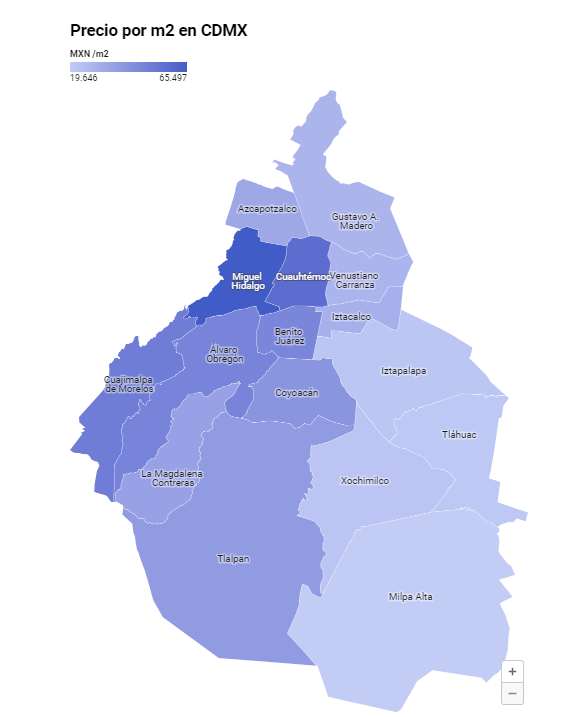

## Listings

## Magdalena Contreras

In [ ]:
listings_Magdalena = listings[listings["neighbourhood_cleansed"] == 'La Magdalena Contreras']

In [ ]:
print(f"Hay {listings_Magdalena.shape[0]} apartamentos en La Magdalena Contreras y {listings_Magdalena[listings_Magdalena['number_of_reviews']>0].shape[0]} con reviews" )

Hay 139 apartamentos en La Magdalena Contreras y 103 con reviews


El número de apartamentos por alcaldía está distribuido de la siguiente forma.

In [ ]:
agg_df_host = listings_Magdalena.groupby(['room_type']).agg({'calculated_host_listings_count': 'count'}).reset_index()
agg_df_host = agg_df_host.sort_values(by='calculated_host_listings_count', ascending=True)

El tipo de apartamento de mayor interés a rentar es un departamento privado, probablemente porque al igual que un departamento entero este igual ofrece comodidad y flexibilidad. Este tipo de alojamiento ofrece una experiencia más cercana a la de estar en casa, lo que cumple con las expectativas de muchos viajeros.

En consecuencia, invertir en departamentos privados podría ser una de las mejores decisiones, dado que son los más rentados y presentan una alta demanda.

Como se puede observar el tipo apartamento compartido es el menos popular, entendble debido a lo mencionado anteriormente

In [ ]:
fig = px.bar(agg_df_host,
             x='calculated_host_listings_count',
             y='room_type',
             orientation='h',
             text='calculated_host_listings_count',
             labels={'calculated_host_listings_count': 'Cantidad de viviendas', 'room_type': 'Tipo de habitación'},
             title="Cantidad de viviendas rentadas por tipo de apartamento en La Mgdalena Contreras")

fig.show()

In [ ]:
#Convirtiendo la columna de price a numérico
listings_Magdalena.loc[:, 'price_numeric'] = listings_Magdalena['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [ ]:
px.box(
    listings_Magdalena,
    x="room_type",
    y="price_numeric",
    labels={'price_numeric': 'Precio', 'room_type': 'Tipo de Habitación'},
    title="BoxPlot de los Precios de las Viviendas por Tipo de Habitación"
)

Como es natural las habitaciones enteras se rentan a un mejor precio que las privadas. Sin embargo, existen habitaciones privadas con buenos precios



In [ ]:
fig = px.histogram(listings_Magdalena, x='price_numeric', color='room_type',
                   barmode='overlay',
                   nbins=30,
                   labels={'price_numeric': 'Precio', 'room_type': 'Tipo de Cuarto'},
                   title='Distribución de Precios por Tipo de Cuarto')

# Mostrar la gráfica
fig.show()

En el rango de precios estándar, que abarca aproximadamente entre 600 MXN y 1,000 MXN, las casas/departamentos completos ofrecen mejores precios por día. Esto sugiere que invertir en este tipo de propiedades puede ser una decisión estratégica.

In [ ]:
fig = px.scatter(listings_Magdalena, x="price_numeric", y="review_scores_rating", color="room_type",symbol = "room_type" ,trendline="ols",
             orientation='h',
             labels={'price_numeric': 'Precio', 'review_scores_rating': 'Rating'},
             title="Precio de los alojamientos vs Calificaciones por tipo de habitación")
fig.show()

**Habitación privada**: Los precios varían bastante, pero en general, los alojamientos con precios más bajos tienden a tener mejores calificaciones. A medida que el precio aumenta, la calificación tiende a ser ligeramente más baja o mantenerse constante.


**Casa/Apartamento completo**: Estos alojamientos tienen una tendencia a mostrar calificaciones ligeramente más altas en precios mayores, lo que sugiere que los huéspedes pueden estar más dispuestos a pagar por una experiencia más completa y privada, manteniendo una alta satisfacción.

In [ ]:
reviews_Magdalena = ['room_type','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']

listings_Magdalena_reviews = listings_Magdalena[reviews_Magdalena]

In [ ]:
# Agrupar por 'room_type' y calcular el promedio de las columnas de puntuación
listings_promedios = listings_Magdalena_reviews.groupby('room_type').mean().reset_index()

# Mostrar el DataFrame con los promedios
listings_promedios

,room_type,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,Entire home/apt,4.741800,4.735200,4.775400,4.791000,4.605800,4.715400
1,Private room,4.848113,4.854717,4.889811,4.900377,4.843962,4.803396
2,Shared room,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
src= 'https://lookerstudio.google.com/embed/reporting/a485830b-3b2a-42ec-a824-ebc43ef2c2ee/page/p_a86e8ahhld'
IPython.display.IFrame(src,width=650, height=300)

Los datos sugieren que, aunque los precios de los alojamientos completos tienden a ser más altos, las habitaciones privadas tienden a tener una ligera ventaja en las calificaciones generales de los usuarios. Esto sugiere que invertir en habitaciones privadas podría ofrecer una buena relación entre precio y satisfacción del cliente considerando que en los reviews todos los puntos mencionados son importantes para brindar una buena experiencia

# Adicionales

Complementando para dar mayor guía en como debe realizar su inversión, se analiza las características promedio de los departamentos que se encuentran en la Magdalena Contreras como es por ejemplo, n. habitaciones, baños, camas ya que como se mencionaba al inicio se busca tener una muy buena experienca del cliente, para enfocar es características se toma los tipos de habitación con review mayor o iguales a 4.5

In [ ]:
src= 'https://lookerstudio.google.com/embed/reporting/a485830b-3b2a-42ec-a824-ebc43ef2c2ee/page/p_g8b8b8xhld'
IPython.display.IFrame(src,width=650, height=300)

Como se muestra en el gráfico, los valores de un apartamento entero son ligeramente más variables que los de una habitación privada, la satisfacción respecto a su alojamiento en habitación privada se mantiene de forma constante aunque se tenga más cantidad en las características, por lo que al realizar la inversión de acuerdo se puede sugerir que sea 1 baño, 1 habitación 1 cama para mantener una experiencia adicional y continuar siendo un lugar rentable y favorito por los huespedes


# Conclusión

Consideramos que una buena oportunidad de inversión es en la Magdalena Contreras en el concepto de habitaciones privadas por 3 ejes principales

1.- Mismo nivel de ingresos potenciales **pero mejor retorno de inversión en el corto plazo**.

2.- Costo de Entrada Más Bajo: Los departamentos con habitaciones privadas generalmente tienen precios de compra y alquiler más bajos en comparación con los alojamientos enteros. Sim embargo, **los datos muestran mayor satisfacción del cliente a este tipo de alojamientos lo que encamina al punto 3**.

3.- Mayor Rentabilidad: La demanda de habitaciones privadas a menudo es alta entre los estudiantes y viajeros, **lo que puede traducirse en tasas de ocupación más elevadas**. Esto puede generar un flujo de ingresos constante y mayor rentabilidad en comparación con unidades que ofrecen solo un espacio privado.

Asì mismo se recomendará seguir todas las instrucciones de las nuevas reformas emitidas por la ciudad de México, cuidando el número de noches alojadas y también si se excede la cantidad seguir la regulasción por Leyes Mercantiles

#Link al tablero

In [5]:
src= 'https://lookerstudio.google.com/embed/reporting/a485830b-3b2a-42ec-a824-ebc43ef2c2ee/page/p_g8b8b8xhld'
IPython.display.IFrame(src,width=900, height=600)